# Analysis

This notebook provides an example of a full processing and analysis pipeline for a reduced dataset.

In [1]:
%load_ext autoreload
%autoreload 2

### Imports

In [2]:
# External packages
import logging
import os
import pprint
import numpy as np
from suite2p import default_ops, version
from IPython.utils import io

# Internal modules
from logger import logger
from constants import *
from fileops import *
from parsers import *
from stackers import stack_tifs
from viewers import view_stack
from filters import KalmanDenoiser, NoFilter
from s2putils import *
from postpro import *
from plotters import *
from utils import *

# Logger level
logger.setLevel(logging.INFO)

# Figures dictionary
figs = {}

### Specify input data directory

In [3]:
# Data directory
dataroot = get_data_root() # Root directory for raw data
date = '11082019'
mouse = 'mouse6'
region = 'region1'
line = 'line3'
datadir = os.path.join(dataroot, date, mouse, region)

## Tif merging

We start by merging individual tif files into a big stack tif file.

### Gather data folders

In [4]:
# Get raw list of subolders containing tifs 
tif_folders = get_data_folders(datadir, exclude_patterns=['MIP', 'References'], include_patterns=[line])
logger.info(f'Identified folders containing TIF files:\n{pprint.pformat([os.path.basename(x) for x in tif_folders])}')

 27/10/2021 16:51:26: Identified folders containing TIF files:
['line3_100frames_100Hz_200ms_3.56Hz_08MPA_60DC-749',
 'line3_100frames_100Hz_200ms_3.56Hz_005MPA_50DC-756',
 'line3_100frames_100Hz_200ms_3.56Hz_08MPA_05DC-748',
 'line3_100frames_100Hz_200ms_3.56Hz_08MPA_50DC-743',
 'line3_100frames_100Hz_200ms_3.56Hz_06MPA_50DC-752',
 'line3_100frames_100Hz_200ms_3.56Hz_08MPA_20DC-746',
 'line3_100frames_100Hz_200ms_3.56Hz_08MPA_30DC-745',
 'line3_100frames_100Hz_200ms_3.56Hz_08MPA_70DC-750',
 'line3_100frames_100Hz_200ms_3.56Hz_08MPA_40DC-744',
 'line3_100frames_100Hz_200ms_3.56Hz_02MPA_50DC-754',
 'line3_100frames_100Hz_200ms_3.56Hz_08MPA_80DC-751',
 'line3_100frames_100Hz_200ms_3.56Hz_01MPA_50DC-755',
 'line3_100frames_100Hz_200ms_3.56Hz_08MPA_10DC-747',
 'line3_100frames_100Hz_200ms_3.56Hz_00MPA_50DC-757',
 'line3_100frames_100Hz_200ms_3.56Hz_04MPA_50DC-753']


### Merge TIFs into stack

In [5]:
stack_fpaths = []
for tif_folder in tif_folders:
    with io.capture_output() as captured:  # turning off warning upon TIF reading
        stack_fpaths.append(stack_tifs(tif_folder, overwrite=False))

 27/10/2021 16:51:26: "/Users/tlemaire/Documents/data/yiyuan/stacked/new_experiments_201911/11082019/mouse6/region1/line3_100frames_100Hz_200ms_3.56Hz_08MPA_60DC-749.tif" already exists
 27/10/2021 16:51:26: "/Users/tlemaire/Documents/data/yiyuan/stacked/new_experiments_201911/11082019/mouse6/region1/line3_100frames_100Hz_200ms_3.56Hz_005MPA_50DC-756.tif" already exists
 27/10/2021 16:51:26: "/Users/tlemaire/Documents/data/yiyuan/stacked/new_experiments_201911/11082019/mouse6/region1/line3_100frames_100Hz_200ms_3.56Hz_08MPA_05DC-748.tif" already exists
 27/10/2021 16:51:26: "/Users/tlemaire/Documents/data/yiyuan/stacked/new_experiments_201911/11082019/mouse6/region1/line3_100frames_100Hz_200ms_3.56Hz_08MPA_50DC-743.tif" already exists
 27/10/2021 16:51:26: "/Users/tlemaire/Documents/data/yiyuan/stacked/new_experiments_201911/11082019/mouse6/region1/line3_100frames_100Hz_200ms_3.56Hz_06MPA_50DC-752.tif" already exists
 27/10/2021 16:51:26: "/Users/tlemaire/Documents/data/yiyuan/stacked/

### Visualize a randomly chosen stack

In [6]:
ifile = 4
figs[f'raw_stack_run{ifile}'] = plot_stack_summary(
    loadtif(stack_fpaths[ifile]),
    title=f'run {ifile} - raw stack')
view_stack(stack_fpaths[ifile], title=f'run {ifile}', ilabels=I_STIM_FRAMES_RUN)

 27/10/2021 16:51:26: loaded (1600, 256, 256) uint16 stack from "/Users/tlemaire/Documents/data/yiyuan/stacked/new_experiments_201911/11082019/mouse6/region1/line3_100frames_100Hz_200ms_3.56Hz_06MPA_50DC-752.tif"
 27/10/2021 16:51:29: initializing stack viewer
 27/10/2021 16:51:29: stack size: (1600, 256, 256)
 27/10/2021 16:51:29: computing stack intensity range across 0 - 1599 frame range...


100%|██████████| 1600/1600 [00:00<00:00, 5463.36it/s]

 27/10/2021 16:51:29: intensity range: 32 - 1906
 27/10/2021 16:51:29: rendering stack view...


We notice a significant amount of Speckle noise in the acquired images, which must be removed.

## Denoising

Let's now use our Kalman filter implementation to denoise the raw TIF stack.

We recall here that our modified Kalman implementation offers the advantages that
- wrong guesses of the initial variance will not prevent noise estimation but merely delay the fitting process.
- an initial baseline padding is used to absorb this fitting process.

Hence, we will fix here default parameters for the variance (`V = 0.05`) and padding length (`n = 10`), and focus our analysis on the main parameter influencing the outcome of this processing step, i.e. the *specified filter gain* (`G`). Ideally, we would like to find the optimal value that efficiently removes Speckle noise while mainting details of transient activity. From collective experience, it seems that values around 0.5 work well when using GCaMP6s as a fluorescence reporter. We will therefore use this value to start with.

In [7]:
# Define Kalman filter
# kd = KalmanDenoiser(G=.5, V=0.05, npad=10)  # real filter object
kd = NoFilter()  # dummy filter object used to work on raw stacks

# Denoise every TIF stack and save outputs in specific directory 
filtered_stack_fpaths = filter_and_save(kd, stack_fpaths, overwrite=False)

### View filtering output for a particular stack

 27/10/2021 16:51:29: loaded (1600, 256, 256) uint16 stack from "/Users/tlemaire/Documents/data/yiyuan/stacked/new_experiments_201911/11082019/mouse6/region1/line3_100frames_100Hz_200ms_3.56Hz_06MPA_50DC-752.tif"


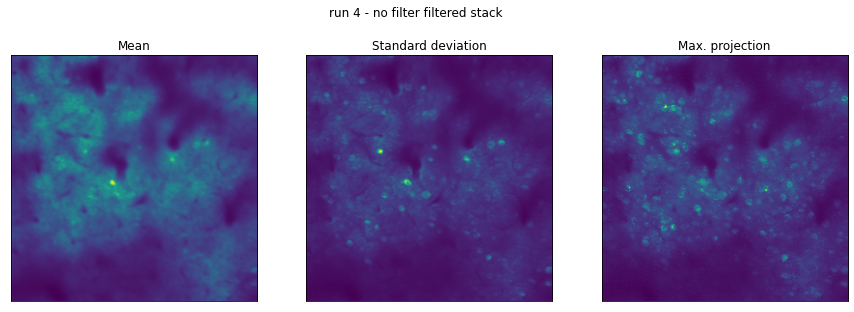

In [8]:
figs[f'filtered_stack_run{ifile}'] = plot_stack_summary(
    loadtif(filtered_stack_fpaths[ifile]),
    title=f'run {ifile} - {kd} filtered stack')

In [9]:
view_stack(
    {'raw': stack_fpaths[ifile], 'filtered': filtered_stack_fpaths[ifile]},
    title=kd, ilabels=I_STIM_FRAMES_RUN, norm=True)

 27/10/2021 16:51:32: initializing stack viewer
 27/10/2021 16:51:32: stack size: (1600, 256, 256)
 27/10/2021 16:51:32: computing stack intensity range across 0 - 1599 frame range...


100%|██████████| 1600/1600 [00:00<00:00, 5401.65it/s]

 27/10/2021 16:51:32: intensity range: 32 - 1906



100%|██████████| 1600/1600 [00:00<00:00, 5396.56it/s]

 27/10/2021 16:51:32: intensity range: 32 - 1906
 27/10/2021 16:51:32: rendering stack view...


## Functional segmentation

We will now use the suite2p pipeline to identify ROIs in our field of view and compute their fluorescence timecourse.

### Determine suite2p input data

In [10]:
# Determine input filepaths (filtered stacks)
s2p_input_fpaths = filtered_stack_fpaths

# Parse input files into info table and extract FPS from it
input_info_table = get_info_table(s2p_input_fpaths, ntrials_per_run=NTRIALS_PER_RUN)
fps = get_singleton(input_info_table, FPS_LABEL)
logger.info(f'parsed frame rate = {fps} fps')

# Get the list of folders containing the input filepaths
# For now, limit ourselves to 1 folder at a time
s2p_input_dirs = list(set(os.path.split(x)[0] for x in s2p_input_fpaths))
assert len(s2p_input_dirs) == 1, 'More than 1 suite2p input directory'
s2p_input_dir = s2p_input_dirs[0]
logger.info(f'Suite2p input directory:\n{s2p_input_dir}')

 27/10/2021 16:51:32: parsed frame rate = 3.56 fps
 27/10/2021 16:51:32: Suite2p input directory:
/Users/tlemaire/Documents/data/yiyuan/stacked/new_experiments_201911/11082019/mouse6/region1


### Set suite2p pipeline parameters

In [11]:
# Custom options
myops = {
    'tau': TAU_GCAMP6_DECAY,  # timescale mof the sensor (in our case GCaMP6s)
    'fs': fps,  # sampling rate (per plane)
    'reg_tif': True,  # whether or not to write the registered binary to tiff files
    'nonrigid': True,  # whether or not to perform non-rigid registration, which splits the field of view into blocks and computes registration offsets in each block separately.
    'denoise': True,  # perform PCA denoising of the registered stack prior to ROI detection 
}

ops = default_ops()  # get default run options
ops.update(myops)  # update with personal options
logger.info(f'Suite2p {version} with run options:\n{pprint.pformat(ops)}')

 27/10/2021 16:51:32: Suite2p 0.10.2 with run options:
{'1Preg': False,
 'align_by_chan': 1,
 'allow_overlap': False,
 'anatomical_only': 0,
 'aspect': 1.0,
 'baseline': 'maximin',
 'batch_size': 500,
 'bidi_corrected': False,
 'bidiphase': 0,
 'block_size': [128, 128],
 'bruker': False,
 'bruker_bidirectional': False,
 'cellprob_threshold': 0.0,
 'chan2_thres': 0.65,
 'classifier_path': 0,
 'combined': True,
 'connected': True,
 'delete_bin': False,
 'denoise': True,
 'diameter': 0,
 'do_bidiphase': False,
 'do_registration': 1,
 'fast_disk': [],
 'flow_threshold': 1.5,
 'force_refImg': False,
 'force_sktiff': False,
 'frames_include': -1,
 'fs': 3.56,
 'functional_chan': 1,
 'h5py': [],
 'h5py_key': 'data',
 'high_pass': 100,
 'ignore_flyback': [],
 'inner_neuropil_radius': 2,
 'keep_movie_raw': False,
 'lam_percentile': 50.0,
 'look_one_level_down': False,
 'max_iterations': 20,
 'max_overlap': 0.75,
 'maxregshift': 0.1,
 'maxregshiftNR': 5,
 'mesoscan': False,
 'min_neuropil_pixels

### Run suite2p

In [12]:
run_suite2p(ops=ops, db={'data_path': s2p_input_dirs}, overwrite='?')

 27/10/2021 16:51:33: found suite2p output files in "/Users/tlemaire/Documents/data/yiyuan/stacked/new_experiments_201911/11082019/mouse6/region1/suite2p/plane0"
 27/10/2021 16:51:33: run options match 100% -> ignoring


### Load suite2p ouput data

In [13]:
s2p_output_fpath = os.path.join(s2p_input_dirs[0], 'suite2p', 'plane0')
s2p_data = get_suite2p_data(s2p_output_fpath, withops=True)
s2p_ops = s2p_data.pop('ops')
output_info_table = get_info_table(s2p_ops['filelist'], ntrials_per_run=NTRIALS_PER_RUN)
output_to_input_mapping = (output_info_table['code'].values[:, None] == input_info_table['code'].values).argmax(axis=0)
nframes_per_trial = get_singleton(output_info_table, NPERTRIAL_LABEL)
nruns = len(s2p_ops['filelist'])
nframes_per_run = list(set(s2p_ops['frames_per_file']))
assert len(nframes_per_run) == 1,  'inconsistent number of frames for each run'
nframes_per_run = nframes_per_run[0]
ntrials_per_run = nframes_per_run // nframes_per_trial
logger.info('output info table corresponding to suite2p processing order:')
output_info_table

 27/10/2021 16:51:33: extracted data contains 470 ROIs
 27/10/2021 16:51:33: output info table corresponding to suite2p processing order:


line  trial_length  duration (s)   fps  P (MPa)  DC (%)  run ID  \
run                                                                     
0    line3           100           0.2  3.56     0.00    50.0     757   
1    line3           100           0.2  3.56     0.10    50.0     755   
2    line3           100           0.2  3.56     0.20    50.0     754   
3    line3           100           0.2  3.56     0.40    50.0     753   
4    line3           100           0.2  3.56     0.05    50.0     756   
5    line3           100           0.2  3.56     0.60    50.0     752   
6    line3           100           0.2  3.56     0.80     5.0     748   
7    line3           100           0.2  3.56     0.80    10.0     747   
8    line3           100           0.2  3.56     0.80    20.0     746   
9    line3           100           0.2  3.56     0.80    30.0     745   
10   line3           100           0.2  3.56     0.80    40.0     744   
11   line3           100           0.2  3.56     0.80    50.0     743   
12   line3           100           0.2  3.56     0.80    60.0     749   
13   line3           100           0.2  3.56     0.80    70.0     750   
14   line3           100           0.2  3.56     0.80    80.0     751   

                                                  code  ntrials  
run                                                              
0    line3_100frames_100Hz_200ms_3.56Hz_00MPA_50DC-757       16  
1    line3_100frames_100Hz_200ms_3.56Hz_01MPA_50DC-755       16  
2    line3_100frames_100Hz_200ms_3.56Hz_02MPA_50DC-754       16  
3    line3_100frames_100Hz_200ms_3.56Hz_04MPA_50DC-753       16  
4    line3_100frames_100Hz_200ms_3.56Hz_005MPA_50DC...       16  
5    line3_100frames_100Hz_200ms_3.56Hz_06MPA_50DC-752       16  
6    line3_100frames_100Hz_200ms_3.56Hz_08MPA_05DC-748       16  
7    line3_100frames_100Hz_200ms_3.56Hz_08MPA_10DC-747       16  
8    line3_100frames_100Hz_200ms_3.56Hz_08MPA_20DC-746       16  
9    line3_100frames_100Hz_200ms_3.56Hz_08MPA_30DC-745       16  
10   line3_100frames_100Hz_200ms_3.56Hz_08MPA_40DC-744       16  
11   line3_100frames_100Hz_200ms_3.56Hz_08MPA_50DC-743       16  
12   line3_100frames_100Hz_200ms_3.56Hz_08MPA_60DC-749       16  
13   line3_100frames_100Hz_200ms_3.56Hz_08MPA_70DC-750       16  
14   line3_100frames_100Hz_200ms_3.56Hz_08MPA_80DC-751       16

### Plot suite2p summary images

In [14]:
figs['registered_images'] = plot_suite2p_registration_images(s2p_ops)

 27/10/2021 16:51:33: plotting suite2p registered images...


### Plot suite2p registration offsets

In [15]:
figs['registered_offsets'] = plot_suite2p_registration_offsets(s2p_ops)

 27/10/2021 16:51:33: plotting suite2p registration offsets...


### Visualize registered stack (for the same run as before)

In [16]:
istimframes_stacked = np.tile(I_STIM_FRAMES_RUN, (nruns, 1))
for i in range(nruns):
    istimframes_stacked[i] += i * REF_NFRAMES
istimframes_stacked = istimframes_stacked.flatten()
ifile_eq = output_to_input_mapping[ifile]
runbounds = [REF_NFRAMES * ifile_eq, REF_NFRAMES * (ifile_eq + 1) - 1]
view_stack(
    s2p_ops, title=f'registered stack (run {ifile} -> output {ifile_eq})',
    bounds=runbounds, ilabels=istimframes_stacked)

 27/10/2021 16:51:33: initializing stack viewer
 27/10/2021 16:51:33: stack size: (24000, 256, 256)
 27/10/2021 16:51:33: frame frange: [8000, 9599]
 27/10/2021 16:51:33: computing stack intensity range across 8000 - 9599 frame range...


100%|██████████| 1600/1600 [00:00<00:00, 6190.71it/s]

 27/10/2021 16:51:34: intensity range: 45 - 404
 27/10/2021 16:51:34: rendering stack view...


### Comparison of average frame intensity for specific run

That is a good opportunity to check that our mapping of input stacks to suite2p output stacks is correct.

In [17]:
fig = plot_mean_evolution(
    {'raw': stack_fpaths[ifile], 'filtered': filtered_stack_fpaths[ifile]})
figs[f'avg_frame_intensity_run{ifile}'] = plot_mean_evolution(
    s2p_ops, title='registered', ilabels=istimframes_stacked, bounds=runbounds, ax=fig.axes[0])

 27/10/2021 16:51:34: initializing stack viewer
 27/10/2021 16:51:34: stack size: (1600, 256, 256)
 27/10/2021 16:51:34: computing stack intensity range across 0 - 1599 frame range...


100%|██████████| 1600/1600 [00:00<00:00, 5694.42it/s]

 27/10/2021 16:51:34: intensity range: 32 - 1906



100%|██████████| 1600/1600 [00:00<00:00, 5195.04it/s]

 27/10/2021 16:51:34: intensity range: 32 - 1906



100%|██████████| 1600/1600 [00:00<00:00, 6176.44it/s]

 27/10/2021 16:51:35: initializing stack viewer
 27/10/2021 16:51:35: stack size: (24000, 256, 256)
 27/10/2021 16:51:35: frame frange: [8000, 9599]
 27/10/2021 16:51:35: computing stack intensity range across 8000 - 9599 frame range...



100%|██████████| 1600/1600 [00:00<00:00, 5814.83it/s]

 27/10/2021 16:51:35: intensity range: 45 - 404



100%|██████████| 1600/1600 [00:01<00:00, 1190.41it/s]


### Inspect suite2p ROIs

 27/10/2021 16:51:37: plotting suite2p identified ROIs...


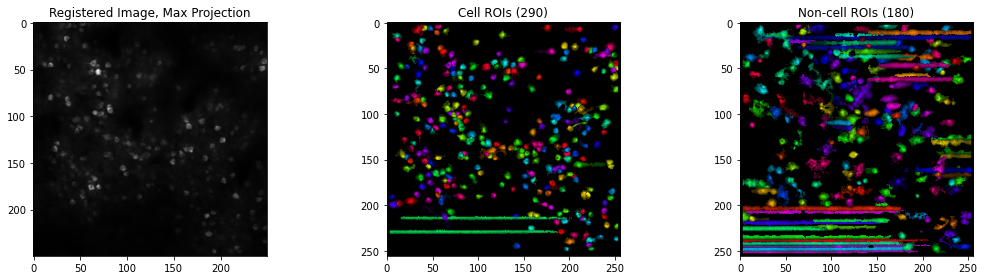

In [18]:
figs['identified_ROIs'] = plot_suite2p_ROIs(s2p_data, s2p_ops)

## Post-processing

### Filter out non-cell ROIs

In [19]:
s2p_data = filter_suite2p_data(s2p_data, s2p_data['iscell'][:, 0].nonzero()[0], 'iscell')
ncells = len(s2p_data['F'])

 27/10/2021 16:51:38: filtering suite2p data to "iscell" criterion...
 27/10/2021 16:51:38: filtered data contains 290 ROIs


### Discard outliers based on morphological properties

 27/10/2021 16:51:39: identified outliers:
    - element 0 (ROI 1)
    - element 226 (ROI 299)
    - element 232 (ROI 323)
    - element 244 (ROI 352)
 27/10/2021 16:51:39: filtering suite2p data to "morphology" criterion...
 27/10/2021 16:51:39: filtered data contains 286 ROIs
 27/10/2021 16:51:39: plotting suite2p identified ROIs...


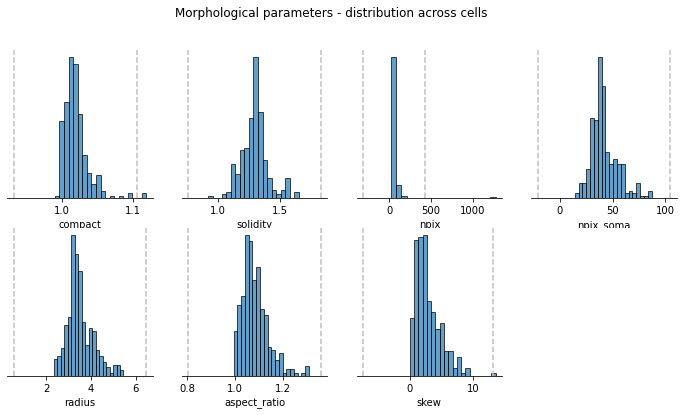

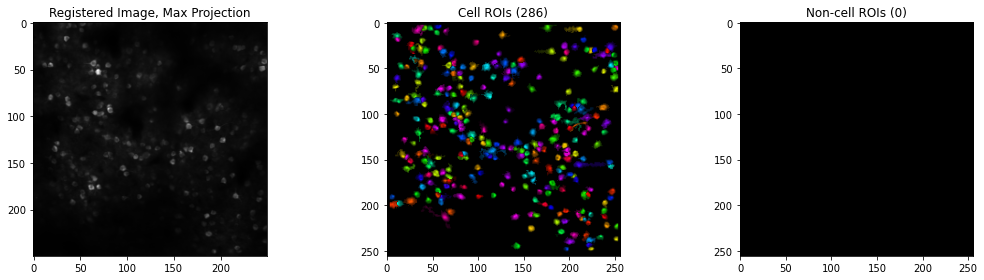

In [20]:
# Plot distributions and identify outliers
pkeys = [
    'compact',
    'solidity',
    'npix',
    'npix_soma',
    'radius',
    'aspect_ratio',
    'skew',
]
figs['morpho_params_cells'], is_outlier = plot_parameter_distributions(s2p_data['stat'], pkeys, zthr=5)
s = '\n'.join([f'    - element {i} (ROI {s2p_data["iROIs"][i]})' for i in is_outlier.nonzero()[0]])
logger.info(f'identified outliers:\n{s}')

# Remove outliers
s2p_data = filter_suite2p_data(s2p_data, ~is_outlier, 'morphology')

# Visualize the new distribution of cells in the field
figs['identified_ROIs'] = plot_suite2p_ROIs(s2p_data, s2p_ops)

### Compute fluorescence data

We also plot the full fluorescence dataset to verify the suite2p output integrity 

In [21]:
logger.info('subtracting fluorescence background...')
F = s2p_data['F'] - NEUROPIL_FACTOR * s2p_data['Fneu']
figs['raw_F_traces'] = plot_raw_traces(
    F, 'all runs', delimiters=np.arange(nruns + 1) * nframes_per_run)

 27/10/2021 16:51:40: subtracting fluorescence background...
 27/10/2021 16:51:40: plotting 286 fluorescence traces...


### Split the data into separate runs

In [22]:
F_per_run = separate_runs(F, nruns)

 27/10/2021 16:51:43: splitting fluorescence array into separate runs...


### Plot fluorescence timecourse for a few runs

 27/10/2021 16:51:43: plotting 286 fluorescence traces...
 27/10/2021 16:51:43: plotting 286 fluorescence traces...
 27/10/2021 16:51:43: plotting 286 fluorescence traces...


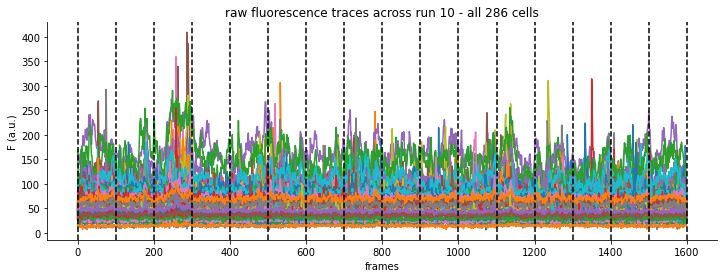

In [23]:
for irun in [3, 7, 10]:
    figs[f'raw_F_traces_run{irun}'] = plot_raw_traces(
        F_per_run[:, irun, :],
        f'run {irun}',
        delimiters=np.arange(ntrials_per_run + 1) * nframes_per_trial)

### Split the fluorescence data into separate trials 

In [24]:
F_per_trial = separate_trials(F_per_run, ntrials_per_run)

 27/10/2021 16:51:45: splitting fluorescence array into separate trials...


### Plot fluorescence timecourse of specific run for a few trials

 27/10/2021 16:51:45: plotting 286 fluorescence traces...
 27/10/2021 16:51:45: plotting 286 fluorescence traces...
 27/10/2021 16:51:45: plotting 286 fluorescence traces...


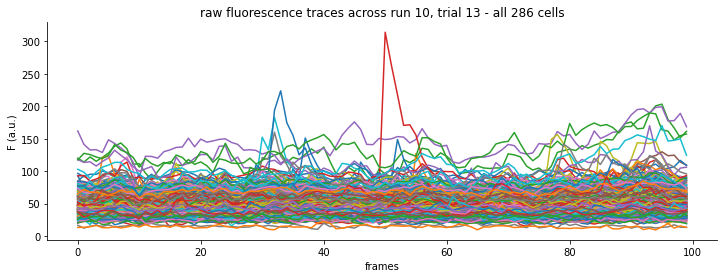

In [25]:
for itrial in [3, 7, 13]:
    figs[f'raw_F_traces_run{irun}_trial{itrial}'] = plot_raw_traces(
        F_per_trial[:, irun, itrial],
        f'run {irun}, trial {itrial}')

### Compute relative fluorescence change for each trial

### <span style="color:red">TODO: Change baseline evaluation???</span>

In [26]:
dFF_per_trial = get_relative_fluorescence_change(F_per_trial, I_BASELINE)

 27/10/2021 16:51:46: computing relative fluorescence change...


### Plot relative fluorescence timecourse of specific run for a few trials

 27/10/2021 16:51:46: plotting 286 fluorescence traces...
 27/10/2021 16:51:47: plotting 286 fluorescence traces...
 27/10/2021 16:51:47: plotting 286 fluorescence traces...


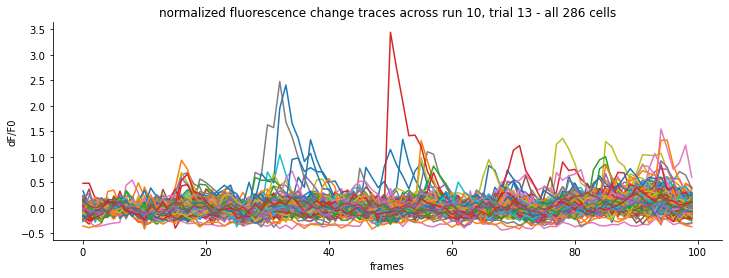

In [27]:
for itrial in [3, 7, 13]:
    figs[f'dFF_traces_run{irun}_trial{itrial}'] = plot_raw_traces(
        dFF_per_trial[:, irun, itrial],
        f'run {irun}, trial {itrial}',
        ylabel=REL_F_CHANGE_LABEL)

### <span style="color:red">TODO: Substitute stim frame for each trial???</span>

### <span style="color:red">TODO: Ignore 1st trial of each run???</span>

### <span style="color:red">TODO: Remove outliers based on fluorescence acitvity???</span>

### Classify cells by response type

In [28]:
# Compute response type for each cell
resp_types, (zmin_dist, zmax_dist) = classify_by_response_type(dFF_per_trial, full_output=True)
s = "\n".join([f"    - {v}: {sum(resp_types == k)}" for k, v in LABEL_BY_TYPE.items()])
logger.info(f'Identified response types classes:\n{s}')
# Plot associated z-scores distributions
figs['zscore_distributions'] = plot_zscore_distributions(zmin_dist, zmax_dist)

 27/10/2021 16:51:47: computing per-run z-score distributions
 27/10/2021 16:51:47: averaging across trials
 27/10/2021 16:51:47: restricting analysis to response interval
 27/10/2021 16:51:47: Identified response types classes:
    - negative: 137
    - neutral: 140
    - positive: 9


### Add everything to global experiment dataframe

In [29]:
# Add cells and trial info to table
data = add_cells_to_table(output_info_table, s2p_data['iROIs'])
del data['code']
data = add_trials_to_table(data)
# Add fluorescence and time signals
# data = add_signal_to_table(data, F_LABEL, F_per_trial)
data = add_signal_to_table(data, REL_F_CHANGE_LABEL, dFF_per_trial)
data = add_time_to_table(data)
# Add response type
data[RESP_LABEL] = resp_types[data.index.get_level_values('cell')]
# Log output
logger.info('data table:')
data

 27/10/2021 16:51:48: adding cells info to table...
 27/10/2021 16:51:48: adding trials info to table...
 27/10/2021 16:51:48: adding dF/F0 signals to table...
 27/10/2021 16:51:52: adding time info to table...
 27/10/2021 16:51:53: data table:


line  duration (s)  P (MPa)  DC (%)  run ID  roi  \
cell run trial frame                                                      
0    0   0     0      line3           0.2      0.0    50.0     757    2   
               1      line3           0.2      0.0    50.0     757    2   
               2      line3           0.2      0.0    50.0     757    2   
               3      line3           0.2      0.0    50.0     757    2   
               4      line3           0.2      0.0    50.0     757    2   
...                     ...           ...      ...     ...     ...  ...   
285  14  15    95     line3           0.2      0.8    80.0     751  468   
               96     line3           0.2      0.8    80.0     751  468   
               97     line3           0.2      0.8    80.0     751  468   
               98     line3           0.2      0.8    80.0     751  468   
               99     line3           0.2      0.8    80.0     751  468   

                         dF/F0   time (s)  response type  
cell run trial frame                                      
0    0   0     0     -0.073815  -2.808989              1  
               1     -0.039962  -2.528090              1  
               2      0.029214  -2.247191              1  
               3     -0.109225  -1.966292              1  
               4      0.065836  -1.685393              1  
...                        ...        ...            ...  
285  14  15    95     0.184807  23.876404             -1  
               96     0.042732  24.157303             -1  
               97     0.075992  24.438202             -1  
               98     0.065697  24.719101             -1  
               99     0.057567  25.000000             -1  

[6864000 rows x 9 columns]

### <span style="color:red">TODO: dataframe smart save/load feature</span>

## Visualizing results 

### Spatial distribution of cells per response type

In [30]:
figs['cellmap'] = plot_cell_map(data, s2p_data, title='cell map by response type')

 27/10/2021 16:51:53: extracting responses types per cell...
 27/10/2021 16:51:54: plotting cells map color-coded by response type...


### Cluster map of cell responses

 27/10/2021 16:51:54: extracting responses types per cell...
 27/10/2021 16:51:55: generating (roi x time) dF/F0 pivot table...
 27/10/2021 16:51:59: generating dF/F0 cluster map...


/opt/anaconda3/envs/suite2p/lib/python3.8/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


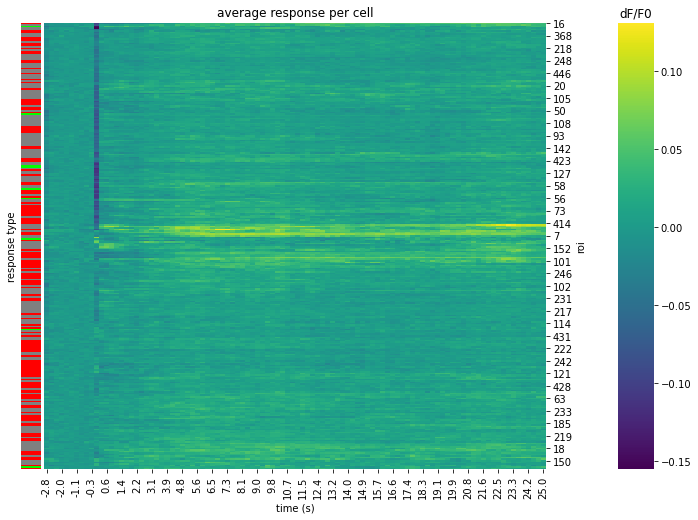

In [31]:
figs['clustermap'] = plot_experiment_heatmap(data, title='average response per cell')

## Plot dF/F0 traces

### for a specific cell and run

 27/10/2021 16:52:00: sub-indexing data...
 27/10/2021 16:52:00: filtering data...
 27/10/2021 16:52:00: extracting responses types per cell...
 27/10/2021 16:52:00: plotting...
 27/10/2021 16:52:00: sub-indexing data...
 27/10/2021 16:52:00: filtering data...
 27/10/2021 16:52:00: extracting responses types per cell...
 27/10/2021 16:52:00: averaging, estimating confidence intervals and plotting...


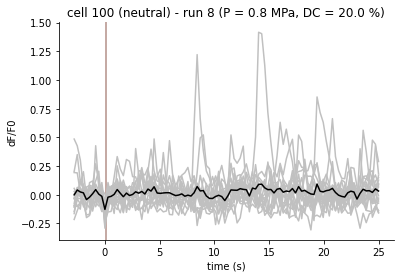

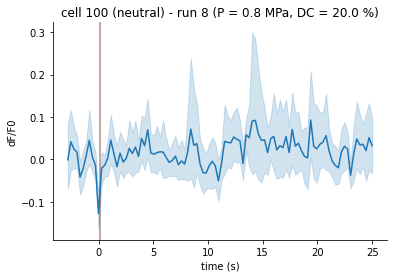

In [32]:
icell = 100
irun = 8
figs[f'response_cell{icell}_run{irun}_traces'] = plot_responses(
    data, icell=icell, irun=irun, aggfunc='traces')
figs[f'response_cell{icell}_run{irun}_ci'] = plot_responses(
    data, icell=icell, irun=irun, aggfunc='mean')

### for a particular (cell, pressure, duty cycle) combination 

 27/10/2021 16:52:02: sub-indexing data...
 27/10/2021 16:52:02: filtering data...
 27/10/2021 16:52:02: extracting responses types per cell...
 27/10/2021 16:52:02: plotting...
 27/10/2021 16:52:02: sub-indexing data...
 27/10/2021 16:52:02: filtering data...
 27/10/2021 16:52:02: extracting responses types per cell...
 27/10/2021 16:52:02: averaging, estimating confidence intervals and plotting...


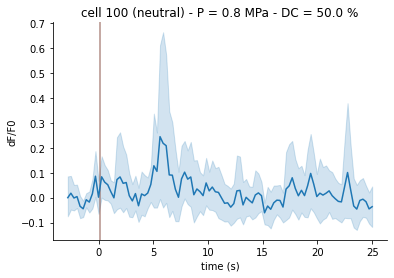

In [33]:
P = P_REF
DC = DC_REF
figs[f'response_cell{icell}_P{P}MPa_DC{DC}%_traces'] = plot_responses(
    data, icell=icell, P=P, DC=DC, aggfunc='traces')
figs[f'response_cell{icell}_P{P}MPa_DC{DC}%_ci'] = plot_responses(
    data, icell=icell, P=P, DC=DC, aggfunc='mean')

### specific (cell, duty cycle), across pressure amplitudes

 27/10/2021 16:52:04: sub-indexing data...
 27/10/2021 16:52:04: filtering data...
 27/10/2021 16:52:04: extracting responses types per cell...
 27/10/2021 16:52:04: grouping by P (MPa), averaging, estimating confidence intervals and plotting...


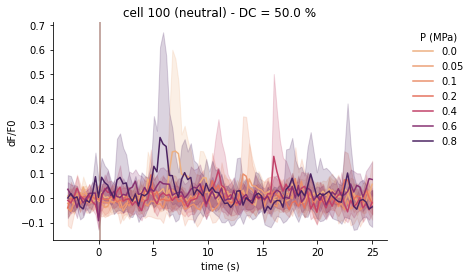

In [34]:
figs[f'response_cell{icell}_DC{DC}%_ci'] = plot_responses(
    data, icell=icell, DC=DC, groupby=P_LABEL)

### specific (cell, pressure), across duty cycles

 27/10/2021 16:52:13: sub-indexing data...
 27/10/2021 16:52:13: filtering data...
 27/10/2021 16:52:13: extracting responses types per cell...
 27/10/2021 16:52:13: grouping by DC (%), averaging, estimating confidence intervals and plotting...


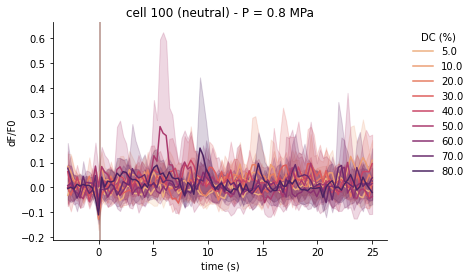

In [35]:
figs[f'response_cell{icell}_P{P}MPa_ci'] = plot_responses(
    data, icell=icell, P=P, groupby=DC_LABEL)

### all cells of a given response type for a particular (pressure, duty cycle) combination 

 27/10/2021 16:52:25: sub-indexing data...
 27/10/2021 16:52:26: filtering data...
 27/10/2021 16:52:27: plotting...
 27/10/2021 16:52:28: sub-indexing data...
 27/10/2021 16:52:30: filtering data...
 27/10/2021 16:52:30: averaging, estimating confidence intervals and plotting...


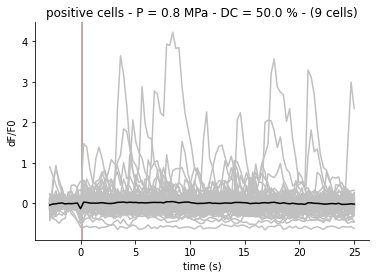

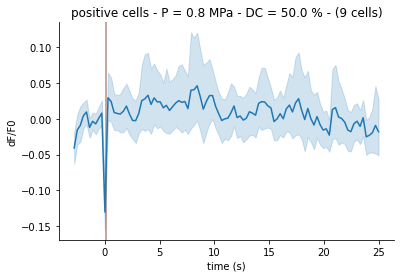

In [36]:
rtype = 1
figs[f'response_{LABEL_BY_TYPE[rtype]}_cells_P{P}MPa_DC{DC}%_traces'] = plot_responses(
    data, rtype=rtype, P=P, DC=DC, aggfunc='traces')
figs[f'response_{LABEL_BY_TYPE[rtype]}_cells_P{P}MPa_DC{DC}%_ci'] = plot_responses(
    data, rtype=rtype, P=P, DC=DC, aggfunc='mean')

### all cells of a given response type for a particular pressure, across duty cycles 

 27/10/2021 16:52:32: sub-indexing data...
 27/10/2021 16:52:34: filtering data...
 27/10/2021 16:52:35: grouping by P (MPa), averaging, estimating confidence intervals and plotting...
 27/10/2021 16:53:12: sub-indexing data...
 27/10/2021 16:53:14: filtering data...
 27/10/2021 16:53:14: grouping by P (MPa), averaging, estimating confidence intervals and plotting...
 27/10/2021 16:53:52: sub-indexing data...
 27/10/2021 16:53:54: filtering data...
 27/10/2021 16:53:54: grouping by P (MPa), averaging, estimating confidence intervals and plotting...


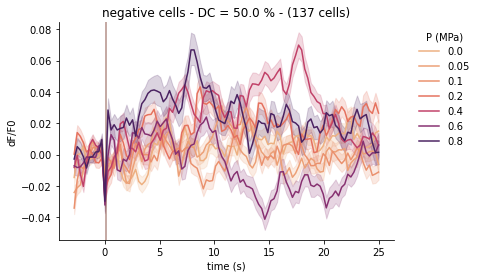

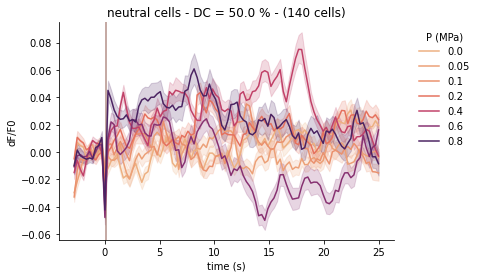

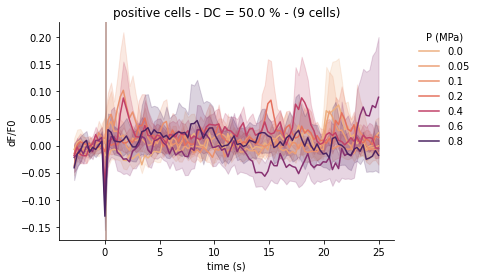

In [37]:
for rtype in [-1, 0, 1]:
    figs[f'response_{LABEL_BY_TYPE[rtype]}_cells_DC{DC}%_ci'] = plot_responses(
        data, DC=DC_REF, rtype=rtype, groupby=P_LABEL)

### all cells of a given response type for a duty cycle, across pressure amplitudes

 27/10/2021 16:54:06: sub-indexing data...
 27/10/2021 16:54:08: filtering data...
 27/10/2021 16:54:08: grouping by DC (%), averaging, estimating confidence intervals and plotting...
 27/10/2021 16:54:57: sub-indexing data...
 27/10/2021 16:54:59: filtering data...
 27/10/2021 16:55:00: grouping by DC (%), averaging, estimating confidence intervals and plotting...
 27/10/2021 16:55:47: sub-indexing data...
 27/10/2021 16:55:49: filtering data...
 27/10/2021 16:55:49: grouping by DC (%), averaging, estimating confidence intervals and plotting...


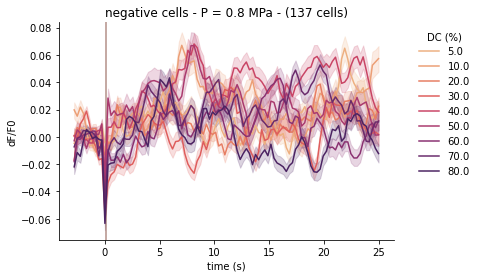

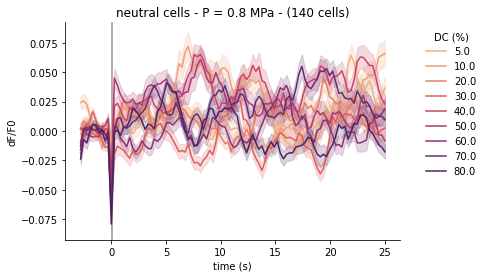

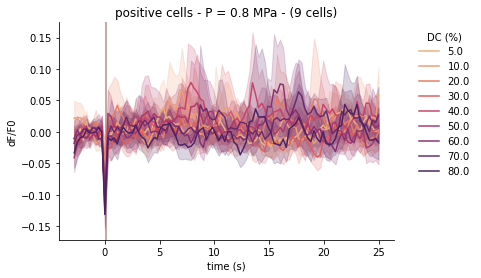

In [38]:
for rtype in [-1, 0, 1]:
    figs[f'response_{LABEL_BY_TYPE[rtype]}_cells_P{P}MPa_ci'] = plot_responses(
        data, P=P_REF, rtype=rtype, groupby=DC_LABEL)

### Save figures

In [39]:
figsdir = os.path.join(s2p_input_dir, 'figs')
save_figs(figsdir, figs)

 27/10/2021 16:56:04: saving "raw_stack_run4.png"
 27/10/2021 16:56:04: saving "filtered_stack_run4.png"
 27/10/2021 16:56:04: saving "registered_images.png"
 27/10/2021 16:56:04: saving "registered_offsets.png"
 27/10/2021 16:56:04: saving "avg_frame_intensity_run4.png"
 27/10/2021 16:56:05: saving "identified_ROIs.png"
 27/10/2021 16:56:05: saving "morpho_params_cells.png"
 27/10/2021 16:56:05: saving "raw_F_traces.png"
 27/10/2021 16:56:08: saving "raw_F_traces_run3.png"
 27/10/2021 16:56:08: saving "raw_F_traces_run7.png"
 27/10/2021 16:56:09: saving "raw_F_traces_run10.png"
 27/10/2021 16:56:09: saving "raw_F_traces_run10_trial3.png"
 27/10/2021 16:56:10: saving "raw_F_traces_run10_trial7.png"
 27/10/2021 16:56:10: saving "raw_F_traces_run10_trial13.png"
 27/10/2021 16:56:10: saving "dFF_traces_run10_trial3.png"
 27/10/2021 16:56:10: saving "dFF_traces_run10_trial7.png"
 27/10/2021 16:56:10: saving "dFF_traces_run10_trial13.png"
 27/10/2021 16:56:10: saving "zscore_distributions.p

### Save stacks as GIFs

In [40]:
#raw and fileted stacks from specific run
save_stack_to_gif(
    figsdir, {'raw': stack_fpaths[ifile], 'filtered': filtered_stack_fpaths[ifile]},
    ilabels=I_STIM_FRAMES_RUN)
# registered stack (slice corresponding to specific run)
save_stack_to_gif(
    figsdir, s2p_ops, title='registered',
    ilabels=istimframes_stacked, bounds=runbounds)

 27/10/2021 16:56:12: initializing stack viewer
 27/10/2021 16:56:12: stack size: (1600, 256, 256)
 27/10/2021 16:56:12: computing stack intensity range across 0 - 1599 frame range...


100%|██████████| 1600/1600 [00:00<00:00, 4236.02it/s]

 27/10/2021 16:56:12: intensity range: 32 - 1906



100%|██████████| 1600/1600 [00:00<00:00, 5603.38it/s]

 27/10/2021 16:56:13: intensity range: 32 - 1906
 27/10/2021 16:56:13: exporting "raw.gif"...



100%|██████████| 1600/1600 [00:13<00:00, 118.99it/s]

 27/10/2021 16:56:26: exporting "filtered.gif"...



100%|██████████| 1600/1600 [00:13<00:00, 123.04it/s]

 27/10/2021 16:56:39: initializing stack viewer
 27/10/2021 16:56:39: stack size: (24000, 256, 256)
 27/10/2021 16:56:39: frame frange: [8000, 9599]
 27/10/2021 16:56:39: computing stack intensity range across 8000 - 9599 frame range...



100%|██████████| 1600/1600 [00:00<00:00, 6227.66it/s]

 27/10/2021 16:56:39: intensity range: 45 - 404
 27/10/2021 16:56:39: exporting "registered.gif"...



100%|██████████| 1600/1600 [00:18<00:00, 87.12it/s]
